In [1327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from pylab import rcParams

In [1328]:
import warnings

warnings.filterwarnings('ignore')

## Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [1329]:
df = pd.read_csv('train.csv', sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [1330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [1331]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


#### Распределение целевой переменной

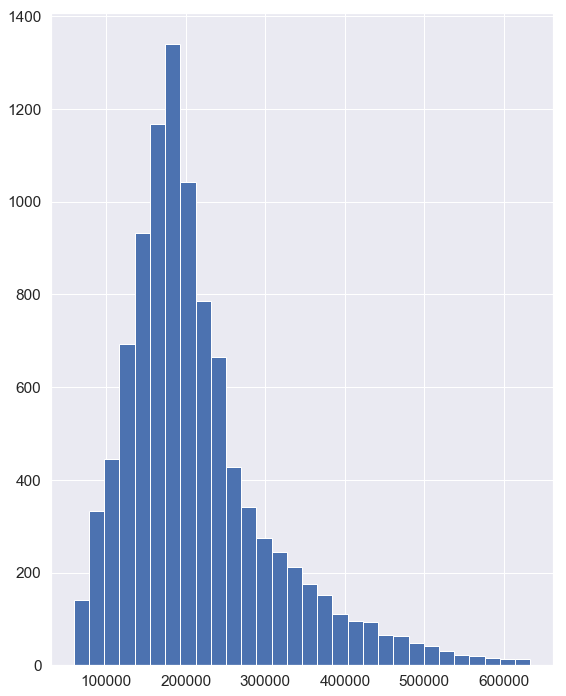

In [1332]:
df['Price'].hist(bins=30)
plt.show()

#### Распределение площади квартир

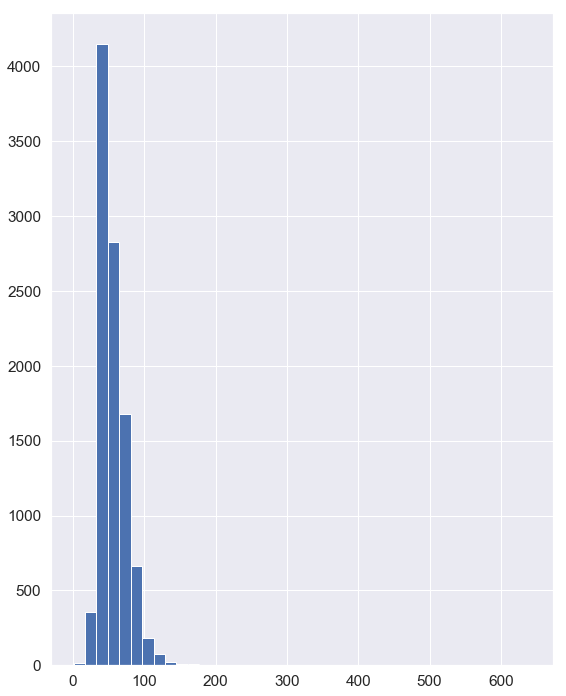

In [1333]:
df['Square'].hist(bins=40)
plt.show()

#### Очистка данных

In [1334]:
# удалили данные, где площадь более 250 и менее 25
df = df[(df['Square'] < 250) & (df['Square'] > 25)]

In [1335]:
# удалили данные, где площадь кухни больше общей площади
df = df[df['Square'] > df['KitchenSquare']]

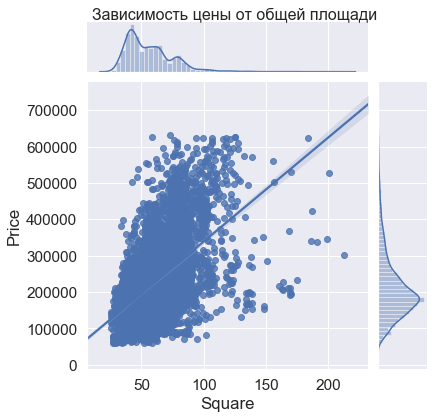

In [1336]:
grid = sns.jointplot(df['Square'], df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
grid.fig.suptitle('Зависимость цены от общей площади', fontsize=16)

plt.show()

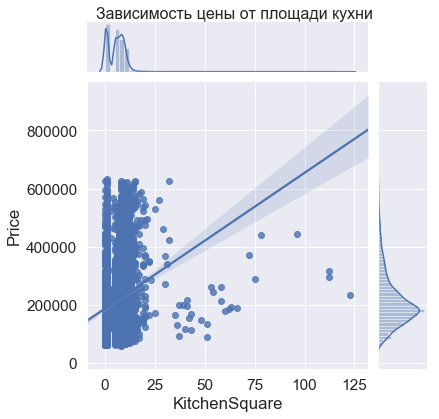

In [1337]:
grid = sns.jointplot(df['KitchenSquare'], df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
grid.fig.suptitle('Зависимость цены от площади кухни', fontsize=16)

plt.show()

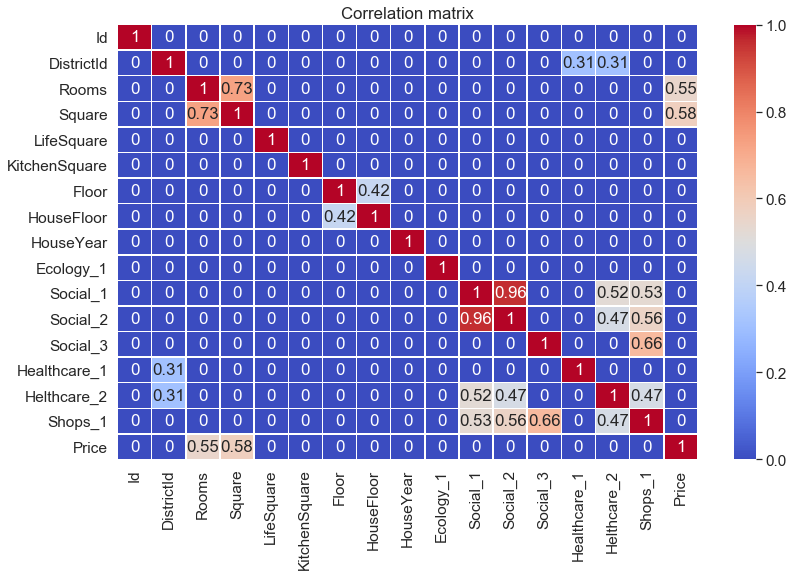

In [1338]:
plt.figure(figsize = (13,8))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### На основании показанных выше графиков избавимся от следующих признаков
- <b>Sosial_1</b> - поскольку высокая корреляция с Social_2
- <b>LifeSquare</b> и <b>KitchenSquare</b> - не обнаружено никаких связей с ценой 
- <b>Id</b> - не несет никакой информативности
- <b>Healthcare_1</b> - больше 50% пропусков

In [1339]:
drop_cols = ['Id', 'Social_2', 'LifeSquare', 'KitchenSquare', 'Healthcare_1']

df.drop(drop_cols, axis=1, inplace=True)

In [1340]:
df.head(10)

,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,27,3.0,115.027313,4,10.0,2014,0.075424,B,B,11,0,0,0,B,305018.875000
1,22,1.0,39.832523,7,8.0,1966,0.118537,B,B,30,1,1,0,B,177734.546875
2,1,3.0,78.342216,2,17.0,1988,0.025609,B,B,33,0,3,1,B,282078.718750
3,1,1.0,40.409908,10,22.0,1977,0.007122,B,B,1,0,0,1,B,168106.000000
4,94,2.0,64.285065,16,16.0,1972,0.282798,B,B,33,2,0,6,B,343995.093750
5,99,3.0,62.528465,9,9.0,1972,0.012339,B,B,35,1,2,4,B,161044.937500
6,44,1.0,33.938751,1,12.0,1968,0.232205,B,B,24,1,0,3,B,142402.734375
7,59,2.0,50.391815,8,17.0,1986,0.019509,B,B,37,11,5,5,B,326174.187500
8,1,1.0,46.887894,12,20.0,1977,0.007122,B,B,1,0,0,1,B,160400.406250
9,6,3.0,79.867477,3,17.0,2014,0.243205,B,B,5,0,0,0,B,194756.031250


In [1341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9958 entries, 0 to 9999
Data columns (total 15 columns):
DistrictId     9958 non-null int16
Rooms          9958 non-null float32
Square         9958 non-null float32
Floor          9958 non-null int8
HouseFloor     9958 non-null float32
HouseYear      9958 non-null int32
Ecology_1      9958 non-null float32
Ecology_2      9958 non-null category
Ecology_3      9958 non-null category
Social_1       9958 non-null int8
Social_3       9958 non-null int16
Helthcare_2    9958 non-null int8
Shops_1        9958 non-null int8
Shops_2        9958 non-null category
Price          9958 non-null float32
dtypes: category(3), float32(5), int16(2), int32(1), int8(4)
memory usage: 418.4 KB


In [1342]:
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9958 entries, 0 to 9999
Data columns (total 18 columns):
DistrictId     9958 non-null int16
Rooms          9958 non-null float32
Square         9958 non-null float32
Floor          9958 non-null int8
HouseFloor     9958 non-null float32
HouseYear      9958 non-null int32
Ecology_1      9958 non-null float32
Social_1       9958 non-null int8
Social_3       9958 non-null int16
Helthcare_2    9958 non-null int8
Shops_1        9958 non-null int8
Price          9958 non-null float32
Ecology_2_A    9958 non-null uint8
Ecology_2_B    9958 non-null uint8
Ecology_3_A    9958 non-null uint8
Ecology_3_B    9958 non-null uint8
Shops_2_A      9958 non-null uint8
Shops_2_B      9958 non-null uint8
dtypes: float32(5), int16(2), int32(1), int8(4), uint8(6)
memory usage: 447.3 KB


#### Разделение датафрейма на целевую переменную и признаки

In [1343]:
X = df.drop('Price', axis=1)
y = df['Price']

In [1344]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [1345]:
X.describe()

,DistrictId,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,9958.000000,9958.00000,9958.000000,9958.000000,9958.000000,9.958000e+03,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000
mean,50.375377,1.89275,56.293972,8.532637,12.623117,3.998641e+03,0.118706,24.680558,8.042478,1.316329,4.232276,0.009440,0.990560,0.027415,0.972585,0.082547,0.917453
std,43.598086,0.83869,18.897465,5.235010,6.766549,2.009226e+05,0.119076,17.540601,23.841794,1.492089,4.808054,0.096703,0.096703,0.163298,0.163298,0.275210,0.275210
min,0.000000,0.00000,25.410513,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.00000,41.830523,4.000000,9.000000,1.974000e+03,0.017647,6.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,35.000000,2.00000,52.609489,7.000000,13.000000,1.977000e+03,0.075424,25.000000,2.000000,1.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.00000,65.932167,12.000000,17.000000,2.001000e+03,0.195781,36.000000,5.000000,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.00000,212.932358,42.000000,117.000000,2.005201e+07,0.521867,74.000000,141.000000,6.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Стандартизация признаков

In [1346]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

#### Построение модели

In [1347]:
from sklearn.neighbors import KNeighborsRegressor

k_values = np.arange(1, 11)

for i, value in enumerate(k_values):
    clf = KNeighborsRegressor(n_neighbors=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    
    r2 = r2_score(y_valid, y_pred)
    
    print(value, ' - ', r2)

1  -  0.5649950707296226
2  -  0.6364755763889285
3  -  0.6610343685161044
4  -  0.6683973093698343
5  -  0.6651913730972792
6  -  0.6701587762817484
7  -  0.6682298249158294
8  -  0.6659370752940827
9  -  0.6638293121142919
10  -  0.6617797706524682


#### Наилучший результат достигается при кол-ве соседей - 6